In [1]:
import copy
import focusedconv
from torchvision.models import vgg16, VGG16_Weights
from utils import build_focused_model

In [2]:
original_vgg = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).eval()
print(original_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [3]:
NUM_TOP_LAYERS = 4
ACTIVATION_BRIGHTNESS_THRESHOLD = 90
focused_vgg = copy.deepcopy(original_vgg)
vgg16_top_layers = copy.deepcopy(original_vgg.features[0: NUM_TOP_LAYERS])
aoi_mask_obj = {"aoi_mask": None}
vgg16_remaining_layers = copy.deepcopy(original_vgg.features[NUM_TOP_LAYERS: ])

focused_vgg = build_focused_model(focused_vgg, vgg16_top_layers, ACTIVATION_BRIGHTNESS_THRESHOLD, vgg16_remaining_layers, aoi_mask_obj)
print(focused_vgg)

VGG(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (1): AoIGenerator()
    (2): Sequential(
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): FocusedConv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): FocusedConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): FocusedConv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): FocusedConv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): FocusedConv2d(256, 256, kernel_si

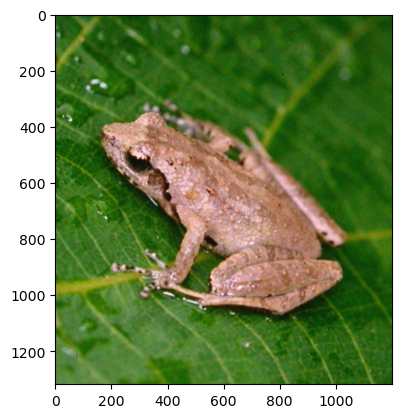

In [4]:
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
IMG_FOLDER = "example_images"
for img_name in os.listdir(IMG_FOLDER):
    img = Image.open(os.path.join(IMG_FOLDER, img_name))
    plt.imshow(np.asarray(img))

/tmp/ipykernel_1085/3037592401.py:12: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  transforms.Resize(256, Image.BICUBIC),


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1, 3, 224, 224])
Do predictions match? tensor(True)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

ORIGINAL AVG: 0.33736228942871094
FOCUSED AVG: 0.270371675491333


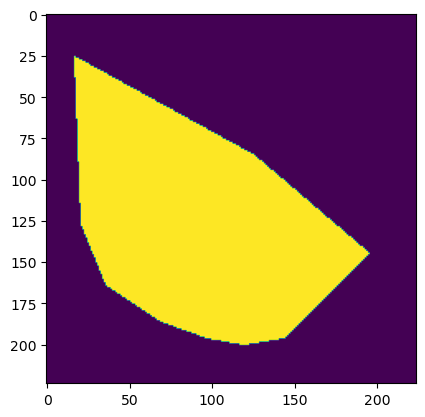

In [6]:
import torchvision.transforms as transforms
import torch
from time import time
from tqdm.notebook import tqdm
from utils import render_aoi_mask
# Define the transforms need to convert dataset to expected
# model input
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
input_transform = transforms.Compose([
    transforms.Resize(256, Image.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])


for img_name in tqdm(os.listdir(IMG_FOLDER)):
    img = Image.open(os.path.join(IMG_FOLDER, img_name))
    plt.imshow(np.asarray(img))
    img_ten = input_transform(img).unsqueeze(0)
    print(img_ten.shape)
    print("Do predictions match?", torch.argmax(original_vgg(img_ten)) == torch.argmax(focused_vgg(img_ten)))
    render_aoi_mask(aoi_mask_obj)
    original_times = []
    focused_times = []
    for i in tqdm(range(10)):
        tick = time()
        original_vgg(img_ten)
        tock = time()
        original_times.append(tock-tick)
    for i in tqdm(range(10)):
        tick = time()
        focused_vgg(img_ten)
        tock = time()
        focused_times.append(tock-tick)

    print("ORIGINAL AVG:", sum(original_times)/len(original_times))
    print("FOCUSED AVG:", sum(focused_times)/len(focused_times))

    

